<a href="https://colab.research.google.com/github/SongheeJo/aiffelthon/blob/main/baselinecode_part3_testipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

import librosa as lb
import librosa.display as lbd
import os

In [2]:
train = pd.read_csv('/content/drive/MyDrive/train.csv')
val= pd.read_csv('/content/drive/MyDrive/val.csv')
train.head()

,Unnamed: 0,pid,filename,disease
0,1572,132,132_2b2_Lr_mc_LittC2SE_1.wav,COPD
1,2266,143,143_1b1_Al_sc_Meditron_17.wav,Healthy
2,561,154,154_4b4_Pr_mc_AKGC417L_4.wav,COPD
3,3165,209,209_1b1_Tc_sc_Meditron_2.wav,Healthy
4,1349,130,130_2b2_Ll_mc_AKGC417L_7.wav,COPD


In [3]:
ytrain = train.disease # 훈련세트의 정답(레이블)
yval = val.disease # 검증세트의 정답(레이블)
yval

0       COPD
1       COPD
2       COPD
3       COPD
4       COPD
        ... 
1720    COPD
1721    COPD
1722    COPD
1723    COPD
1724    COPD
Name: disease, Length: 1725, dtype: object

In [4]:
ytrain

0          COPD
1       Healthy
2          COPD
3       Healthy
4          COPD
         ...   
5168       COPD
5169       COPD
5170       COPD
5171       COPD
5172       COPD
Name: disease, Length: 5173, dtype: object

In [5]:
# LabelEncoder - object인 레이블(정답)의 자료형을 모델에 넣기 위해 숫자로 변환
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
ytrain = le.fit_transform(ytrain)
yval = le.transform(yval)

# Feature Extraction

리브로사의 feture extraction 방식을 써보자! + 1-by-1으로 각각의 성능을 확인하자!


In [6]:
def getFeatures(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate) # 오디오 데이터에서 특성을 뽑는 가장 대표적인 방법
    cstft=lb.feature.chroma_stft(y=soundArr, sr=sample_rate) # 특성 추출 방법2
    mSpec=lb.feature.melspectrogram(y=soundArr, sr=sample_rate) # 특성 추출 방법3 - 스펙트로그램에 인간의 귀가 주파수 대역이 높고 낮음에 따라 소리를 둔하게/민감하게 받아들이는 정도를 반영하는 mel-scale을 적용하여 구하는 mel-filter bank라는 필터를 적용해서 얻음

    return mfcc, cstft, mSpec

# to these function,

In [7]:
# train, val셋 iteration - lb.featureextraction 
# val 셋
root='/content/drive/MyDrive/processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]
i=0
for idx, row in val.iterrows():
    path=root + row['filename']
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)

mfcc_val=np.array(mfcc)
cstft_val=np.array(cstft)
mSpec_val=np.array(mSpec)


/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [8]:
print(mfcc_val) # append의 결과가 궁금하다.

[[[-510.1834  -510.1834  -510.1834  ... -510.1834  -510.1834  -510.1834 ]
  [   0.         0.         0.      ...    0.         0.         0.     ]
  [   0.         0.         0.      ...    0.         0.         0.     ]
  ...
  [   0.         0.         0.      ...    0.         0.         0.     ]
  [   0.         0.         0.      ...    0.         0.         0.     ]
  [   0.         0.         0.      ...    0.         0.         0.     ]]

 [[-479.44424 -479.44424 -479.44424 ... -479.44424 -479.44424 -479.44424]
  [   0.         0.         0.      ...    0.         0.         0.     ]
  [   0.         0.         0.      ...    0.         0.         0.     ]
  ...
  [   0.         0.         0.      ...    0.         0.         0.     ]
  [   0.         0.         0.      ...    0.         0.         0.     ]
  [   0.         0.         0.      ...    0.         0.         0.     ]]

 [[-448.7851  -448.7851  -448.7851  ... -448.7851  -448.7851  -448.7851 ]
  [   0.         0.   

In [9]:
# train 셋
root='/content/drive/MyDrive/processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]
i=0
for idx,row in train.iterrows():
    path=root + row['filename']
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    
mfcc_train=np.array(mfcc)
cstft_train=np.array(cstft)
mSpec_train=np.array(mSpec)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


# Testing Features
Let's create model using Keras Functional API to check how the features perform.

* Functional API(함수형 API)
케라스의 모델 설계 방식은 Sequential API와 Fuctional API 두 가지가 있다. Sequential API는 단순히 층을 쌓는 것으로 직관적이고 편리하다. 하지만 좀 더 복잡한 신경망은 구현할 수 없다. Fuctional API는 Sequential API만으로는 구현할 수 없는 모델을 만들 수 있다. (여러 층을 공유하거나 다양한 종류의 입력과 출력을 사용하는 등..)

In [10]:
my_callbacks = [
                tf.keras.callbacks.EarlyStopping(patience=5),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                                     patience=3, min_lr=0.00001, mode='min'),
                tf.keras.callbacks.ModelCheckpoint('hbNet', monitor='val_loss', verbose=0, save_best_only=True,)
]

3가지 CNN을 만들고, 이것들 Dense Network로 combine

In [11]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")

In [12]:
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mfccInput (InputLayer)      [(None, 20, 259, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 87, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 20, 87, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 87, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 43, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 22, 64)        18

In [13]:
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")

In [14]:
croma_model.summary()

Model: "cromaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cromaInput (InputLayer)     [(None, 12, 259, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 87, 32)        832       
                                                                 
 batch_normalization_4 (Batc  (None, 12, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 12, 87, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 43, 32)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 22, 64)         1

In [15]:
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")

In [16]:
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mSpecInput (InputLayer)     [(None, 128, 259, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 87, 32)        832       
                                                                 
 batch_normalization_7 (Batc  (None, 64, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 64, 87, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 22, 64)        1

In [17]:
# combining 3*CNN 모델
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,croma,mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(8,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net") # 이름은 net로 하자.

In [18]:
net.summary()

Model: "Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 croma (InputLayer)             [(None, 12, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 mspec (InputLayer)             [(None, 128, 259, 1  0           []                               
                                )]                                                              

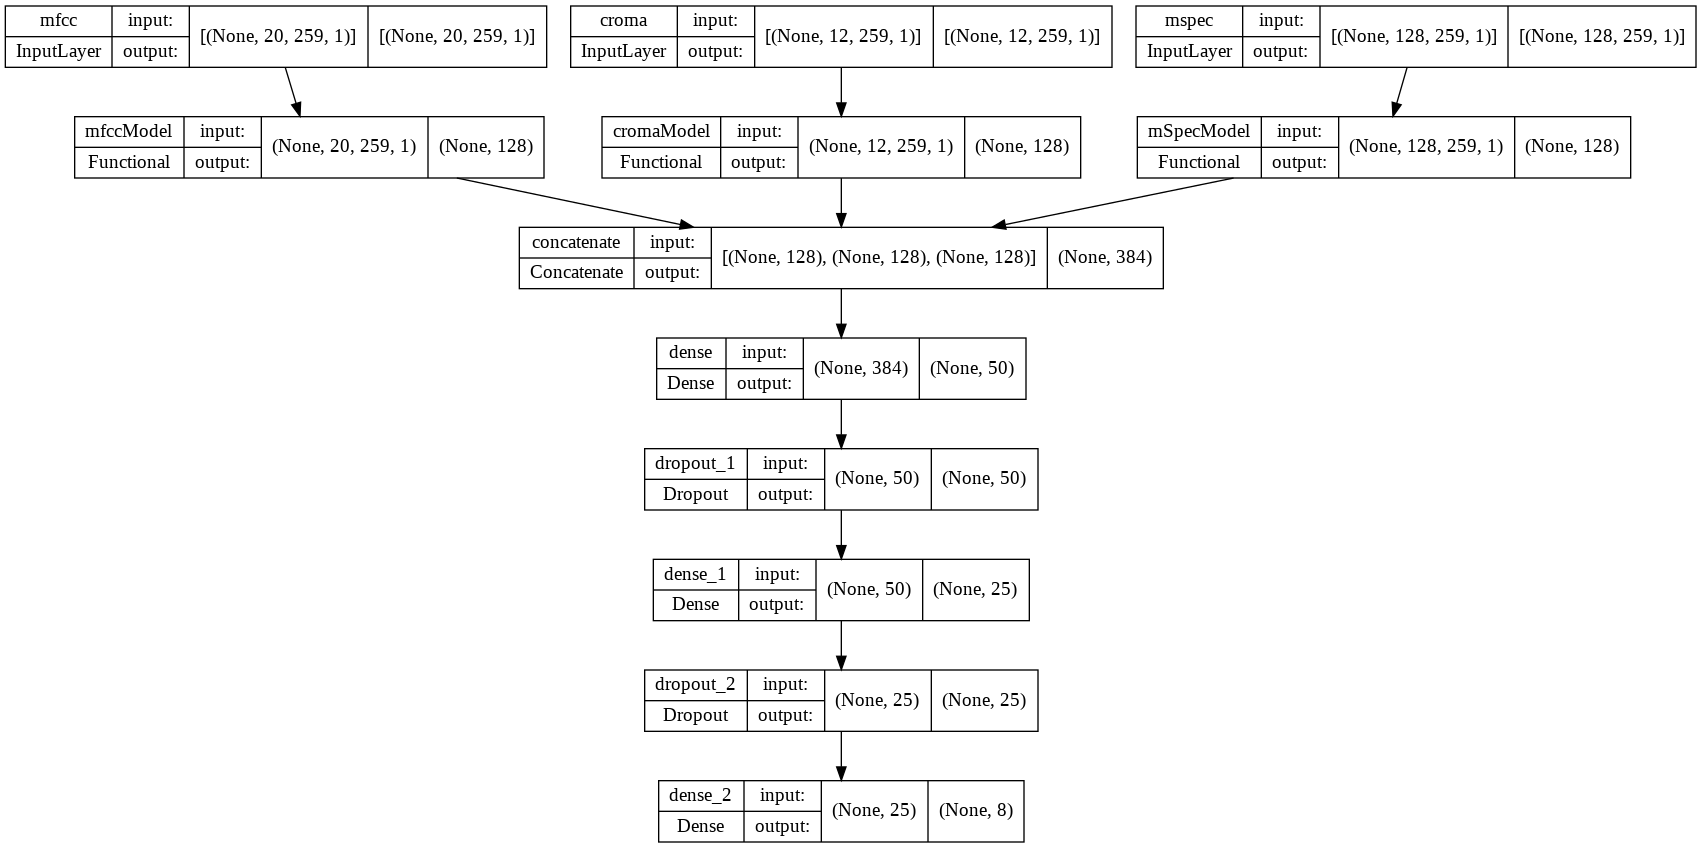

In [19]:
keras.utils.plot_model(net, "net.png", show_shapes=True)

In [20]:
accuracy='sparse_categorical_accuracy'
sparseLoss=keras.losses.SparseCategoricalCrossentropy()

from keras import backend as K
K.clear_session()
net.compile(optimizer='nadam', loss=sparseLoss,metrics=[accuracy])
K.set_value(net.optimizer.learning_rate, 0.001)

In [21]:

history=net.fit(
    {"mfcc":mfcc_train,"croma":cstft_train,"mspec":mSpec_train},
    ytrain,
    validation_data=({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval),
    epochs=100,verbose=0,
    callbacks=my_callbacks
)

INFO:tensorflow:Assets written to: hbNet/assets
INFO:tensorflow:Assets written to: hbNet/assets
INFO:tensorflow:Assets written to: hbNet/assets
INFO:tensorflow:Assets written to: hbNet/assets
INFO:tensorflow:Assets written to: hbNet/assets
INFO:tensorflow:Assets written to: hbNet/assets
INFO:tensorflow:Assets written to: hbNet/assets
INFO:tensorflow:Assets written to: hbNet/assets
INFO:tensorflow:Assets written to: hbNet/assets
INFO:tensorflow:Assets written to: hbNet/assets
INFO:tensorflow:Assets written to: hbNet/assets
INFO:tensorflow:Assets written to: hbNet/assets
INFO:tensorflow:Assets written to: hbNet/assets
INFO:tensorflow:Assets written to: hbNet/assets
INFO:tensorflow:Assets written to: hbNet/assets
INFO:tensorflow:Assets written to: hbNet/assets


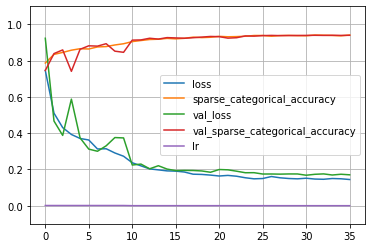

In [22]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1, 1.1) # gca() - Get the current Axes instance on the current figure matching the given keyword args, or create one.
plt.show()

* The model is a little less accurate but this must account to the use of classes that have very less samples, you can crop these out and i am sure this will improve accuracy to 98% accuracy.
<-- HOW??

In [23]:
net.evaluate({"mfcc":mfcc_val, "croma":cstft_val, "mspec":mSpec_val},yval)

54/54 [==============================] - 0s 6ms/step - loss: 0.1703 - sparse_categorical_accuracy: 0.9403


[0.1703372299671173, 0.9402898550033569]

In [24]:
model=keras.models.load_model('./hbNet')

In [25]:
model.compile(optimizer='nadam', loss=sparseLoss,metrics=[accuracy])

In [26]:
loss, acc = model.evaluate({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval,verbose=2)
print('Restroed model, accuracy: {:5.2f}%'.format(100*acc))

54/54 - 1s - loss: 0.1680 - sparse_categorical_accuracy: 0.9397 - 709ms/epoch - 13ms/step
Restroed model, accuracy: 93.97%
